## Example performing two simple ensemble estimations: 1. statistics-maximum; 2. coherence-semblance
Written by Congcong Yuan, 2023-02

### Outline of this tutorial

0. Choose your environment
1. Import packages and functions
   - installed packages in the environment
   - functions from this toolkit ('ELEP')
2. Load the data and models
   - download one example earthquake data
   - load base models from seisbench
3. Base predictions from pretrained models
4. Ensemble estimations
   - ensemble maximum
   - ensemble semblance

#### 0. Choose your environment

In [35]:
env_option = 'colab'

if env_option == 'local':
    # work on the local machine
    # ensure you have created an environment for ELEP
    # and installed the required packages
    pass
    
elif env_option == 'colab':
    # install the required packages by pip3 on virtual machine
    !pip3 install seisbench
    !pip3 install ELEP==0.0.2 

#### 1. import packages and functions

In [1]:
# import modules from created environment
import numpy as np
import pandas as pd
import sys
import copy
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import time

import matplotlib.pyplot as plt

import seisbench.models as sbm

from ELEP.elep.ensemble_statistics import ensemble_statistics
from ELEP.elep.ensemble_coherence import ensemble_semblance 
from ELEP.elep.ensemble_learners import ensemble_regressor_cnn
from ELEP.elep import mbf, mbf_utils
from ELEP.elep import trigger_func

from ELEP.elep.mbf_utils import make_LogFq, make_LinFq, rec_filter_coeff, create_obspy_trace
from ELEP.elep.mbf import MB_filter as MBF

# Note: in case you failed to install ELEP, you can use the following codes to import functions from downloaded ELEP package
# add environment path to sys.path
# sys.path.append('../../ELEP/elep/')
# import functions from ELEP
# from ensemble_coherence import ensemble_semblance
# from ensemble_statistics import ensemble_statistics

#### 2. load data and models

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

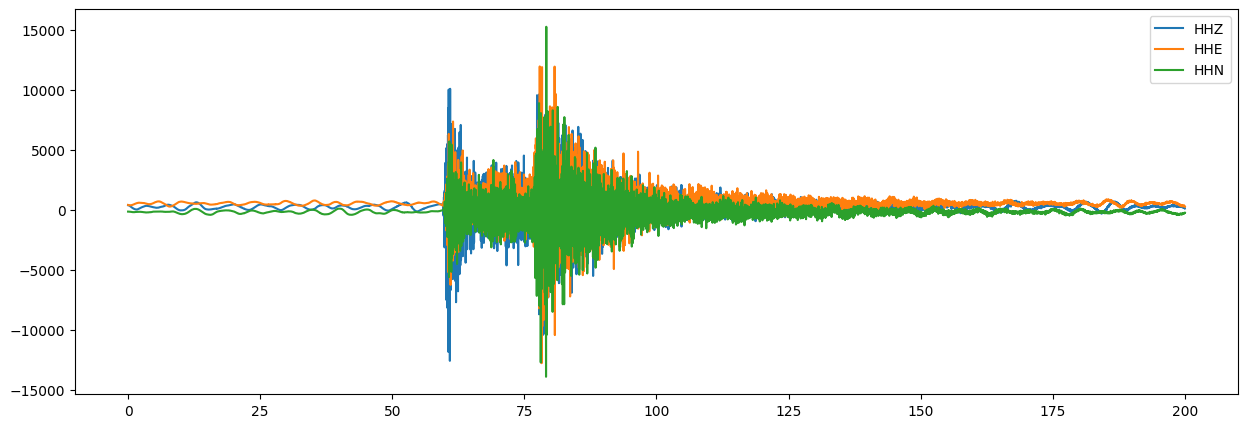

In [2]:
# download example waveforms
starttime = UTCDateTime("2007/01/02 05:48:50")
net, sta, loc, chan = "CX", "PB01", "*", "HH?"
client = Client("GFZ")

stream = client.get_waveforms(network=net, station=sta, location=loc, channel=chan, starttime=starttime-50, endtime=starttime+150)

# plot example waveforms
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend()
plt.show()

In [3]:
# list all pretrained models from seisbench 
# see details here: https://seisbench.readthedocs.io/en/stable/pages/models.html 
print(f'Pretrained models built on PhaseNet: {sbm.PhaseNet.list_pretrained()}')
print(f'Pretrained models built on GPD: {sbm.GPD.list_pretrained()}')
print(f'Pretrained models built on EqTransformer: {sbm.EQTransformer.list_pretrained()}')

Pretrained models built on PhaseNet: ['diting', 'ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'obs', 'original', 'scedc', 'stead']
Pretrained models built on GPD: ['dummy', 'ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'original', 'scedc', 'stead']
Pretrained models built on EqTransformer: ['ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'obs', 'original', 'original_nonconservative', 'scedc', 'stead']


In [4]:
# load pretrained models from seibench
# datasets for pretrained models: https://seisbench.readthedocs.io/en/stable/pages/benchmark_datasets.html 
# Various pre-trained weights for PhaseNet
pn_ethz_model = sbm.PhaseNet.from_pretrained("ethz")
pn_instance_model = sbm.PhaseNet.from_pretrained("instance")
pn_scedc_model = sbm.PhaseNet.from_pretrained("scedc")
pn_stead_model = sbm.PhaseNet.from_pretrained("stead")
pn_geofon_model = sbm.PhaseNet.from_pretrained("geofon")
pn_neic_model = sbm.PhaseNet.from_pretrained("neic")

# # Various pre-trained weights for GPD
gpd_original_model = sbm.GPD.from_pretrained("original")
gpd_ethz_model = sbm.GPD.from_pretrained("ethz")
gpd_scedc_model = sbm.GPD.from_pretrained("scedc")
gpd_stead_model = sbm.GPD.from_pretrained("stead")
gpd_geofon_model = sbm.GPD.from_pretrained("geofon")
gpd_neic_model = sbm.GPD.from_pretrained("neic")

# Various pre-trained weights for EQT
# eqt_original_model = sbm.EQTransformer.from_pretrained("original")
eqt_original_model = sbm.EQTransformer.from_pretrained("original_nonconservative")
eqt_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
eqt_instance_model = sbm.EQTransformer.from_pretrained("instance")
eqt_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
eqt_stead_model = sbm.EQTransformer.from_pretrained("stead")
eqt_geofon_model = sbm.EQTransformer.from_pretrained("geofon")

2023-05-06 16:11:39,534 | seisbench | WARNING | Weight version warning: The normalization for this weight version is incorrect and will lead to degraded performance. Run from_pretrained with update=True once to solve this issue. For details, see https://github.com/seisbench/seisbench/pull/188 .
2023-05-06 16:11:39,569 | seisbench | WARNING | Weight version warning: The normalization for this weight version is incorrect and will lead to degraded performance. Run from_pretrained with update=True once to solve this issue. For details, see https://github.com/seisbench/seisbench/pull/188 .
2023-05-06 16:11:39,608 | seisbench | WARNING | Weight version warning: The normalization for this weight version is incorrect and will lead to degraded performance. Run from_pretrained with update=True once to solve this issue. For details, see https://github.com/seisbench/seisbench/pull/188 .
2023-05-06 16:11:39,644 | seisbench | WARNING | Weight version warning: The normalization for this weight versio

#### 3. base predictions from pretrained models

In [5]:
# model prediction
time0 = time.time()

pn_ethz_annotations = pn_ethz_model.annotate(stream)
pn_instance_annotations = pn_instance_model.annotate(stream)
pn_scedc_annotations = pn_scedc_model.annotate(stream)
pn_stead_annotations = pn_stead_model.annotate(stream)
pn_geofon_annotations = pn_geofon_model.annotate(stream)
pn_neic_annotations = pn_neic_model.annotate(stream)

gpd_origional_annotations = gpd_original_model.annotate(stream)
gpd_ethz_annotations = gpd_ethz_model.annotate(stream)
gpd_scedc_annotations = gpd_scedc_model.annotate(stream)
gpd_stead_annotations = gpd_stead_model.annotate(stream)
gpd_geofon_annotations = gpd_geofon_model.annotate(stream)
gpd_neic_annotations = gpd_neic_model.annotate(stream)

eqt_origional_annotations = eqt_original_model.annotate(stream)
eqt_ethz_annotations = eqt_ethz_model.annotate(stream)
eqt_instance_annotations = eqt_instance_model.annotate(stream)
eqt_scedc_annotations = eqt_scedc_model.annotate(stream)
eqt_geofon_annotations = eqt_geofon_model.annotate(stream)
eqt_stead_annotations = eqt_stead_model.annotate(stream)

time1 = time.time()
print(f'Time cost on the prediction = {time1-time0} s')

Time cost on the prediction = 6.195148944854736 s


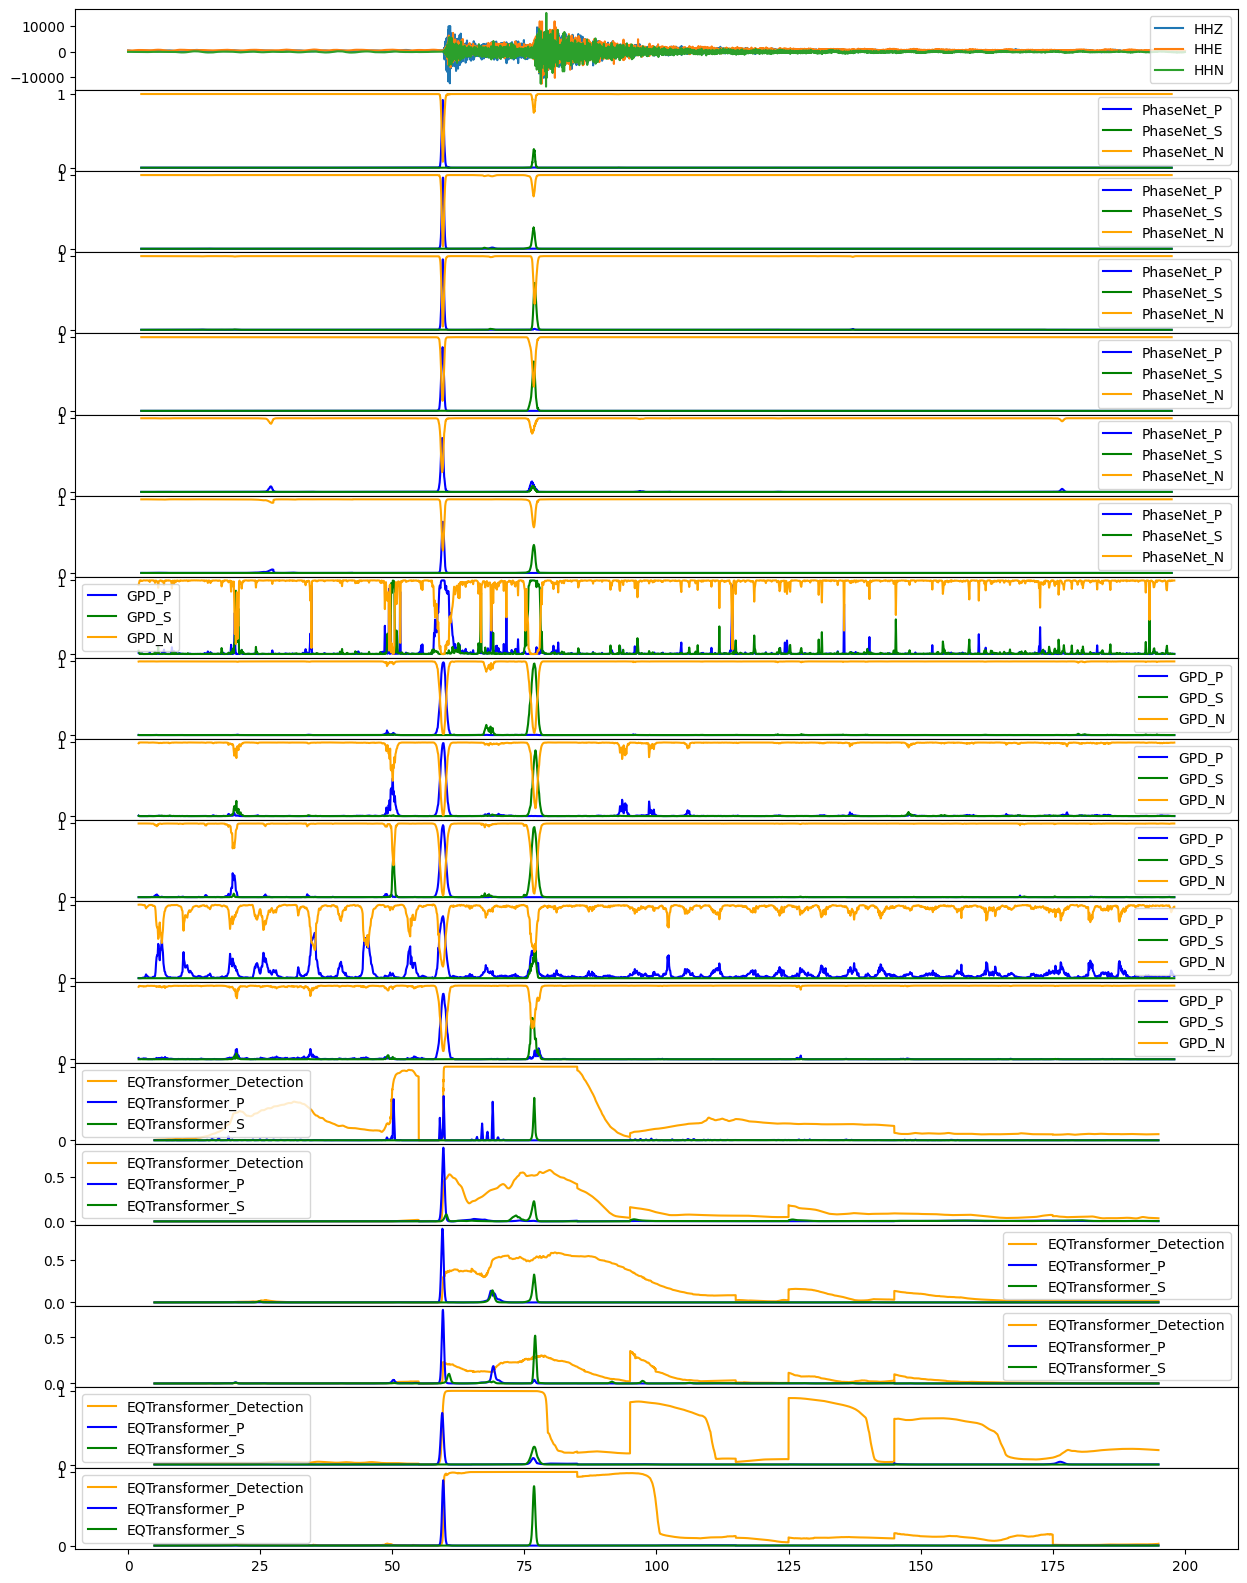

In [6]:
# visialization predicted results
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(19, 1, sharex=True, gridspec_kw={'hspace': 0})

annotations_list = [pn_ethz_annotations, pn_instance_annotations, pn_scedc_annotations, pn_stead_annotations, pn_geofon_annotations, pn_neic_annotations,
                    gpd_origional_annotations, gpd_ethz_annotations, gpd_scedc_annotations, gpd_stead_annotations, gpd_geofon_annotations, gpd_neic_annotations,
                    eqt_origional_annotations, eqt_ethz_annotations, eqt_instance_annotations, eqt_scedc_annotations, eqt_geofon_annotations, eqt_stead_annotations]

for i in range(3):
    axs[0].plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
axs[0].legend()

color_pn_list, color_gpd_list, color_eqt_list = ['blue', 'green', 'orange'], ['blue', 'green', 'orange'], ['orange', 'blue', 'green']
for ii, annotations in enumerate(annotations_list):
    offset = annotations[0].stats.starttime - stream[0].stats.starttime
    mdl = annotations[0].stats.channel.split('_')[0]
    if mdl == 'PhaseNet':
        for ic in range(3):
            axs[ii+1].plot(annotations[ic].times() + offset, annotations[ic].data, color=color_pn_list[ic], label=annotations[ic].stats.channel)
    elif mdl == 'GPD':
        for ic in range(3):
            axs[ii+1].plot(annotations[ic].times() + offset, annotations[ic].data, color=color_gpd_list[ic], label=annotations[ic].stats.channel)
    elif mdl == 'EQTransformer':
        for ic in range(3):
            axs[ii+1].plot(annotations[ic].times() + offset, annotations[ic].data, color=color_eqt_list[ic], label=annotations[ic].stats.channel)    
    axs[ii+1].legend()

#### 4. ensemble maximum and ensemble semblance based on phasenet predictions

In [7]:
# collect up all the predictions
# ntr = len(annotations_list)
# npts = len(stream[0].data)
# preds_P, preds_S = np.zeros([ntr, npts]), np.zeros([ntr, npts])

# for ii, annotations in enumerate(annotations_list):
#     annotations.resample(100.)
#     mdl = annotations[0].stats.channel.split('_')[0]
#     offset = int((annotations[0].stats.starttime - stream[0].stats.starttime)/0.01)
#     if mdl == 'PhaseNet':
#         mpts = len(annotations[0].data)
#         preds_P[ii,offset:mpts+offset] = annotations[0].data
#         preds_S[ii,offset:mpts+offset] = annotations[1].data
#     elif mdl == 'GPD':
#         mpts = len(annotations[0].data)
#         preds_P[ii,offset:mpts+offset] = annotations[0].data
#         preds_S[ii,offset:mpts+offset] = annotations[1].data
#     elif mdl == 'EQTransformer':
#         mpts = len(annotations[0].data)
#         preds_P[ii,offset:mpts+offset] = annotations[1].data
#         preds_S[ii,offset:mpts+offset] = annotations[2].data

# collect up predictions from EQTransformer
pn_annotations_list = [pn_ethz_annotations, pn_instance_annotations, pn_scedc_annotations, pn_stead_annotations, pn_geofon_annotations, pn_neic_annotations]

ntr = len(pn_annotations_list)
npts = len(stream[0].data)
preds_P, preds_S = np.zeros([ntr, npts]), np.zeros([ntr, npts])

for ii, annotations in enumerate(pn_annotations_list):
    annotations.resample(100.)
    mdl = annotations[0].stats.channel.split('_')[0]
    offset = int((annotations[0].stats.starttime - stream[0].stats.starttime)/0.01)
    if mdl == 'PhaseNet':
        mpts = len(annotations[0].data)
        preds_P[ii,offset:mpts+offset] = annotations[0].data
        preds_S[ii,offset:mpts+offset] = annotations[1].data
    else:
        pass

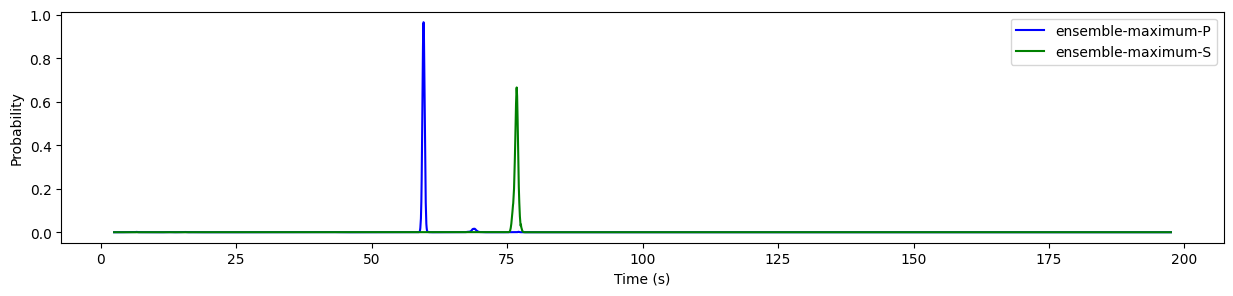

In [8]:
# ensemble maximum
paras_maximum = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
max_pred_P = ensemble_statistics(preds_P, paras_maximum)
max_pred_S = ensemble_statistics(preds_S, paras_maximum)

# plot final result
fig = plt.figure(figsize=(15, 3))
plt.plot(annotations[0].times()+offset*0.01, max_pred_P[offset:mpts+offset], 'b', label='ensemble-maximum-P')
plt.plot(annotations[0].times()+offset*0.01, max_pred_S[offset:mpts+offset], 'g', label='ensemble-maximum-S')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.show()

/opt/anaconda3/envs/ELEP/lib/python3.10/site-packages/ELEP/elep/ensemble_coherence.py:64: RuntimeWarning: invalid value encountered in divide
  semblance0 = sums_num/sums_den


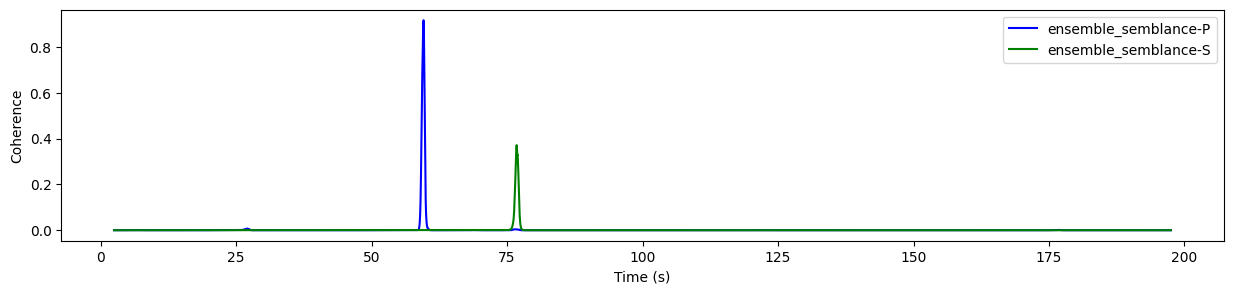

In [9]:
# find semblenace/coherence    
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':True, 'semblance_win':0.5, 'weight_flag':'max'}
smb_pred_P = ensemble_semblance(preds_P, paras_semblance)
smb_pred_S = ensemble_semblance(preds_S, paras_semblance)

# plot final result
fig = plt.figure(figsize=(15, 3))
plt.plot(annotations[0].times()+offset*0.01, smb_pred_P[offset:mpts+offset], 'b', label='ensemble_semblance-P')
plt.plot(annotations[0].times()+offset*0.01, smb_pred_S[offset:mpts+offset], 'g', label='ensemble_semblance-S')
plt.xlabel('Time (s)')
plt.ylabel('Coherence')
plt.legend()
plt.show()

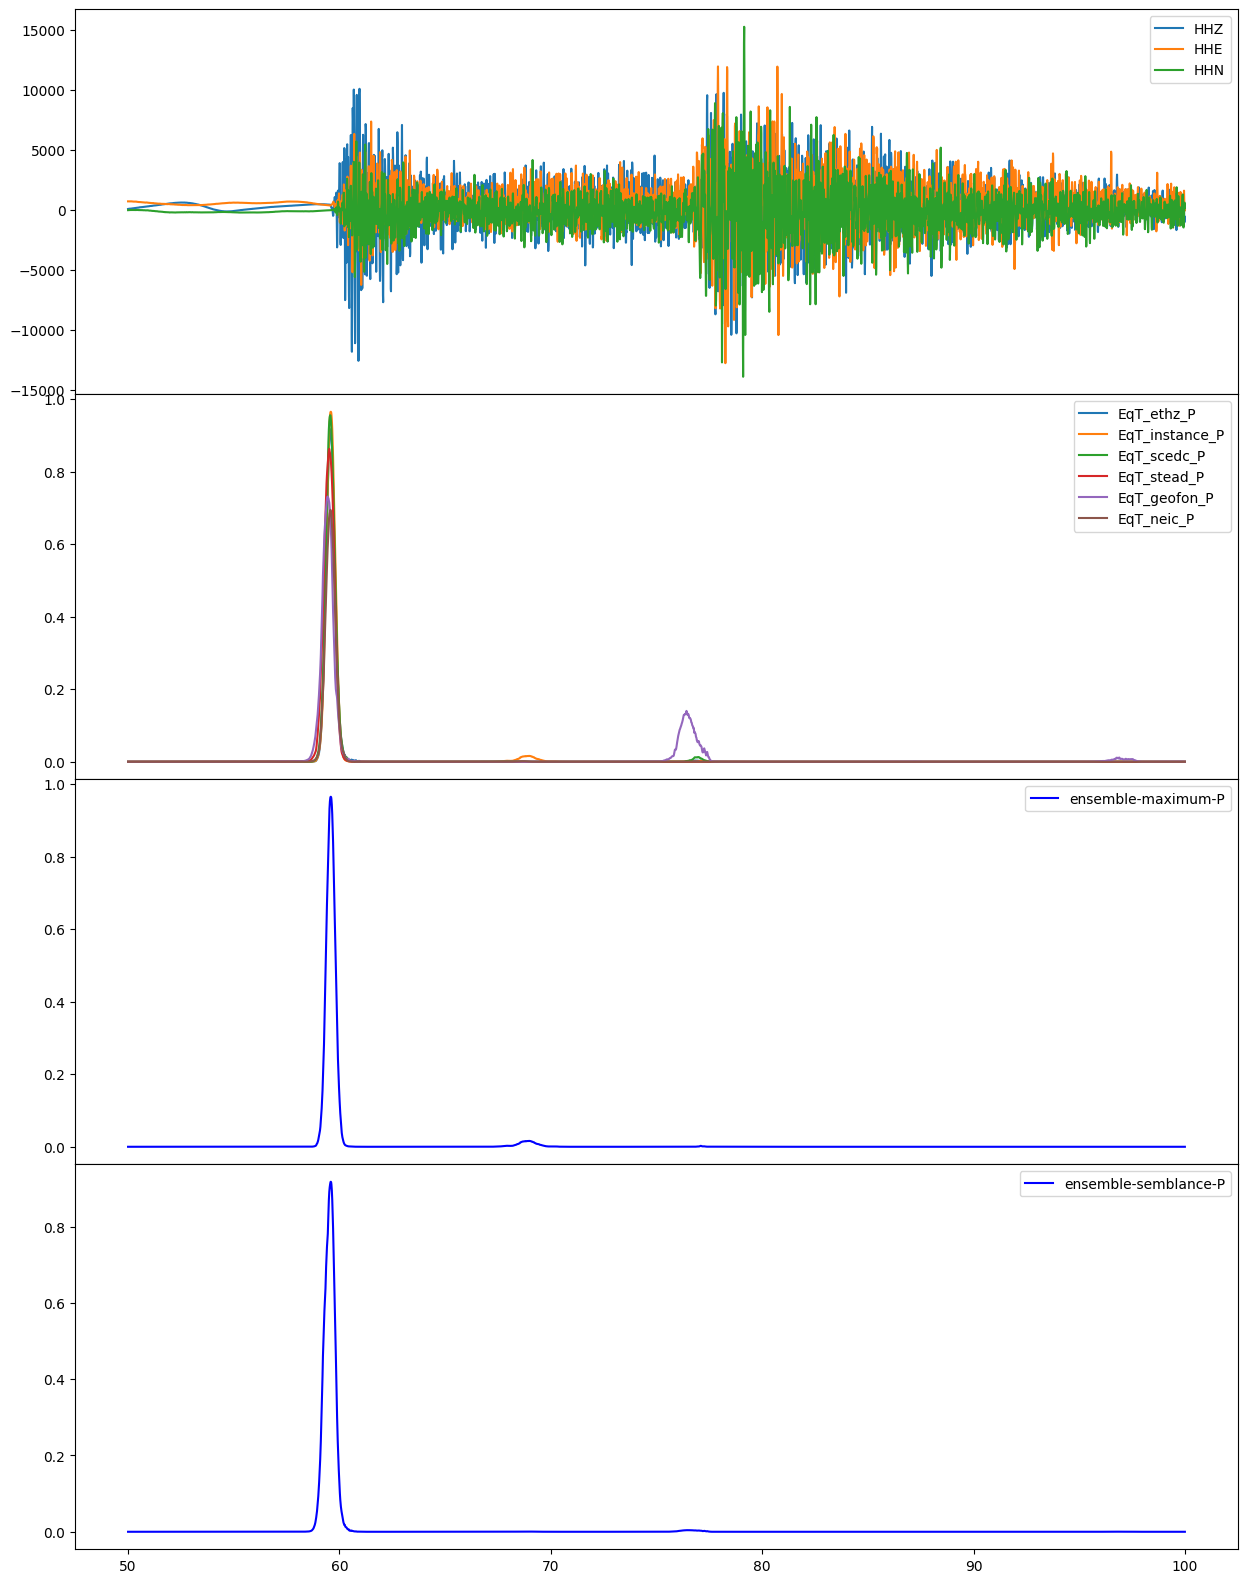

In [10]:
# compare base predictions and simple ensemble for P estimation
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0})

pretrain_mdl_list = ['ethz', 'instance', 'scedc', 'stead', 'geofon', 'neic']

# plot zoomed-in data
for i in range(3):
    tvec = stream[i].times()
    tind = np.where((tvec >= 50) & (tvec <= 100))[0]
    axs[0].plot(tvec[tind], stream[i].data[tind], label=stream[i].stats.channel)

# plot all eqt predictions
for ii in range(ntr):    
    axs[1].plot(tvec[tind], preds_P[ii,tind], label='EqT_'+pretrain_mdl_list[ii]+'_P')
    
# plot ensemble maximum estimation
axs[2].plot(tvec[tind], max_pred_P[tind], 'b', label='ensemble-maximum-P')

# plot ensemble semblance estimation
axs[3].plot(tvec[tind], smb_pred_P[tind], 'b', label='ensemble-semblance-P')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

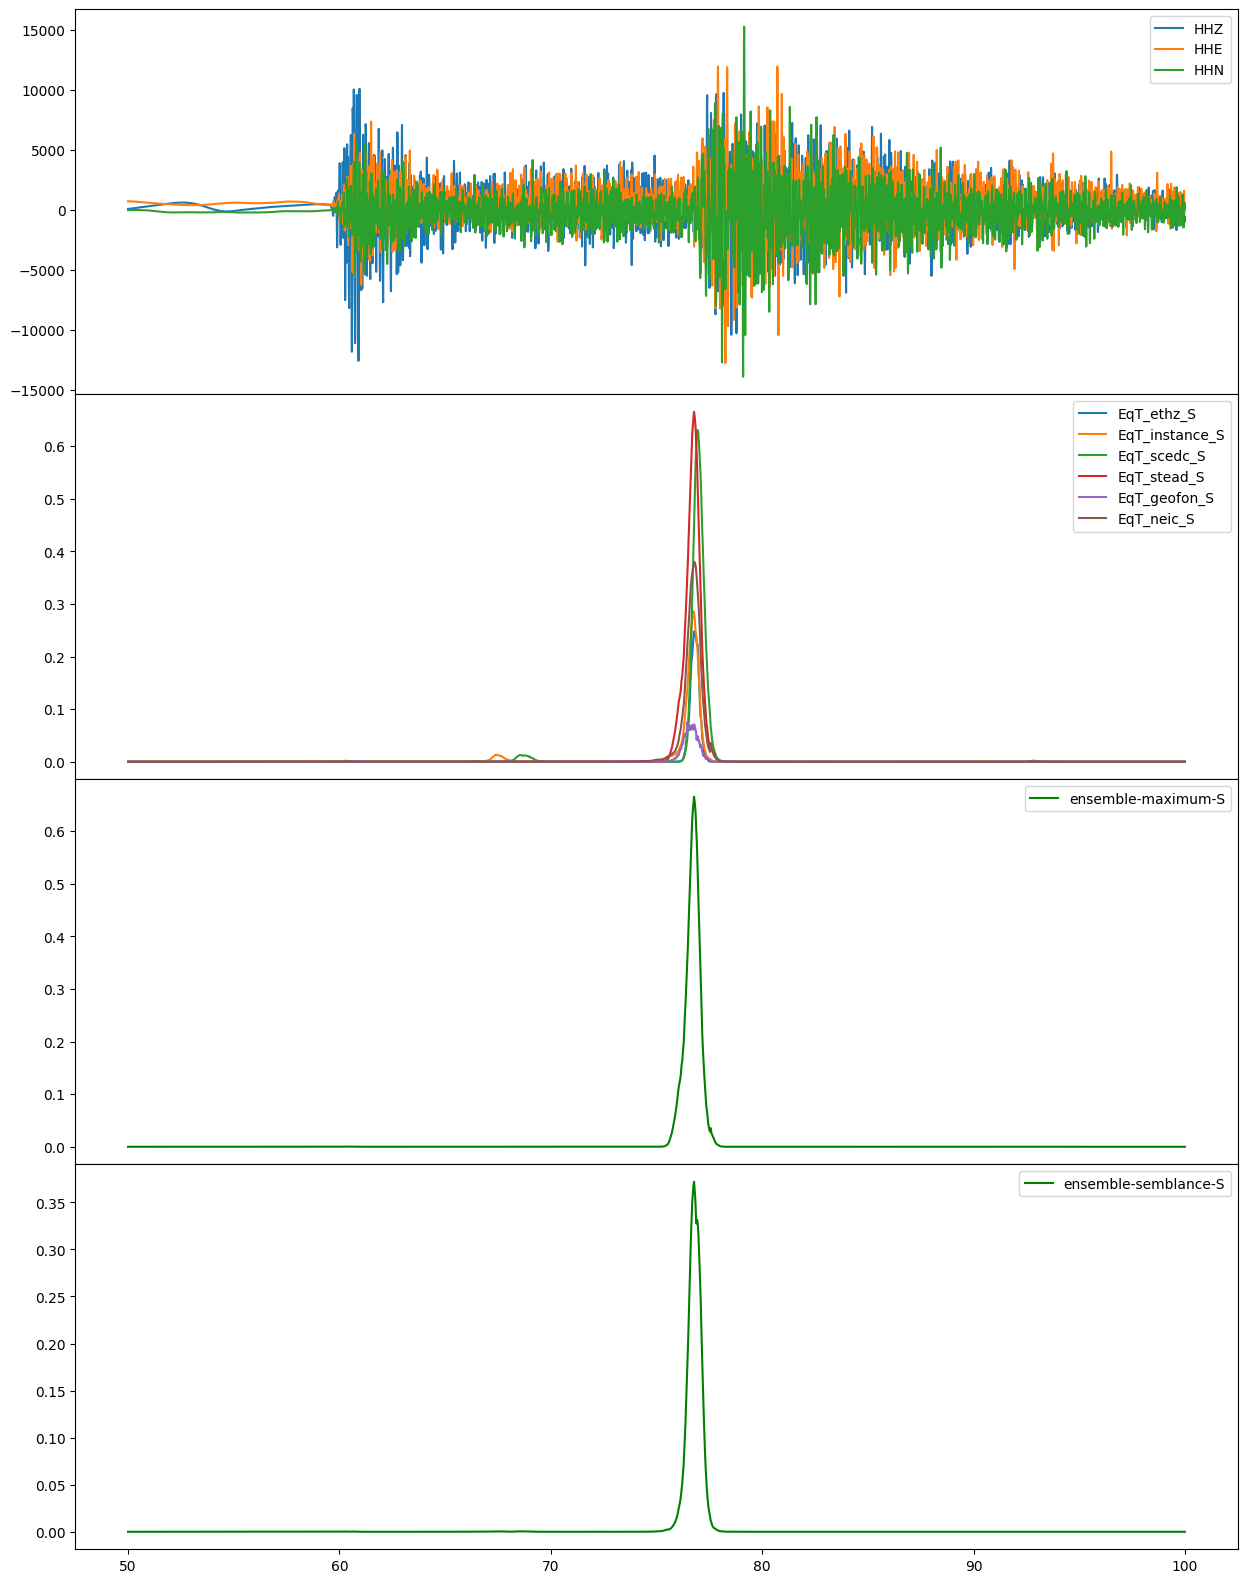

In [11]:
# compare base predictions and simple ensemble for S estimation
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0})

# plot zoomed-in data
for i in range(3):
    tvec = stream[i].times()
    tind = np.where((tvec >= 50) & (tvec <= 100))[0]
    axs[0].plot(tvec[tind], stream[i].data[tind], label=stream[i].stats.channel)

# plot all eqt predictions
for ii in range(ntr):    
    axs[1].plot(tvec[tind], preds_S[ii,tind], label='EqT_'+pretrain_mdl_list[ii]+'_S')
    
# plot ensemble maximum estimation
axs[2].plot(tvec[tind], max_pred_S[tind], 'g', label='ensemble-maximum-S')

# plot ensemble semblance estimation
axs[3].plot(tvec[tind], smb_pred_S[tind], 'g', label='ensemble-semblance-S')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

#### 4. ensemble maximum and ensemble semblance based on eqtransformer predictions

In [12]:
# collect up predictions from EQTransformer
eqt_annotations_list = [eqt_origional_annotations, eqt_ethz_annotations, eqt_instance_annotations, eqt_scedc_annotations, eqt_geofon_annotations, eqt_stead_annotations]

ntr = len(eqt_annotations_list)
npts = len(stream[0].data)
preds_P, preds_S = np.zeros([ntr, npts]), np.zeros([ntr, npts])

for ii, annotations in enumerate(eqt_annotations_list):
    annotations.resample(100.)
    mdl = annotations[0].stats.channel.split('_')[0]
    offset = int((annotations[0].stats.starttime - stream[0].stats.starttime)/0.01)
    if mdl == 'EQTransformer':
        mpts = len(annotations[0].data)
        preds_P[ii,offset:mpts+offset] = annotations[1].data
        preds_S[ii,offset:mpts+offset] = annotations[2].data
    else:
        pass

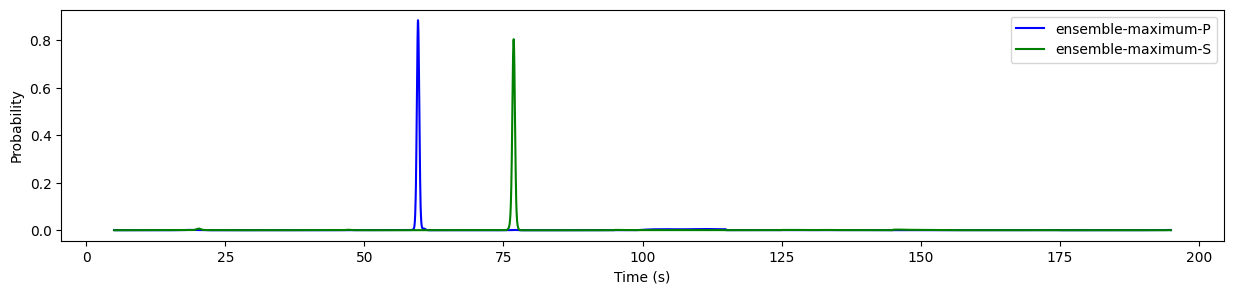

In [13]:
# ensemble maximum
paras_maximum = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
max_pred_P = ensemble_statistics(preds_P, paras_maximum)
max_pred_S = ensemble_statistics(preds_S, paras_maximum)

# plot final result
fig = plt.figure(figsize=(15, 3))
plt.plot(annotations[0].times()+offset*0.01, max_pred_P[offset:mpts+offset], 'b', label='ensemble-maximum-P')
plt.plot(annotations[0].times()+offset*0.01, max_pred_S[offset:mpts+offset], 'g', label='ensemble-maximum-S')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.show()

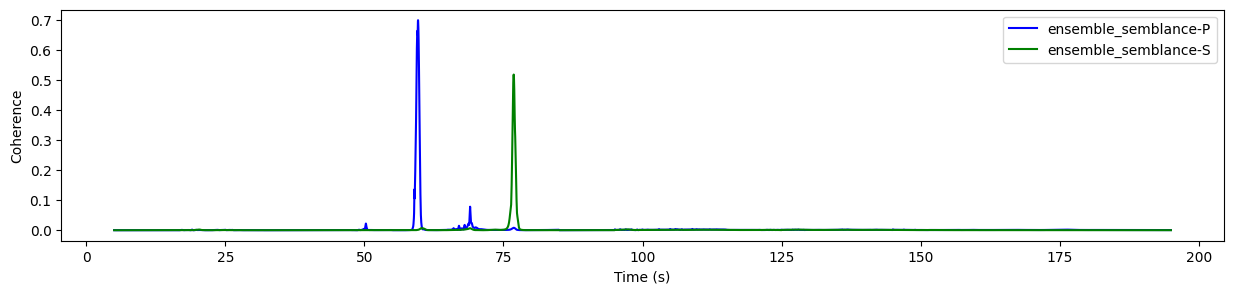

In [14]:
# find semblenace/coherence    
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':True, 'semblance_win':0.5, 'weight_flag':'max'}
smb_pred_P = ensemble_semblance(preds_P, paras_semblance)
smb_pred_S = ensemble_semblance(preds_S, paras_semblance)

# plot final result
fig = plt.figure(figsize=(15, 3))
plt.plot(annotations[0].times()+offset*0.01, smb_pred_P[offset:mpts+offset], 'b', label='ensemble_semblance-P')
plt.plot(annotations[0].times()+offset*0.01, smb_pred_S[offset:mpts+offset], 'g', label='ensemble_semblance-S')
plt.xlabel('Time (s)')
plt.ylabel('Coherence')
plt.legend()
plt.show()

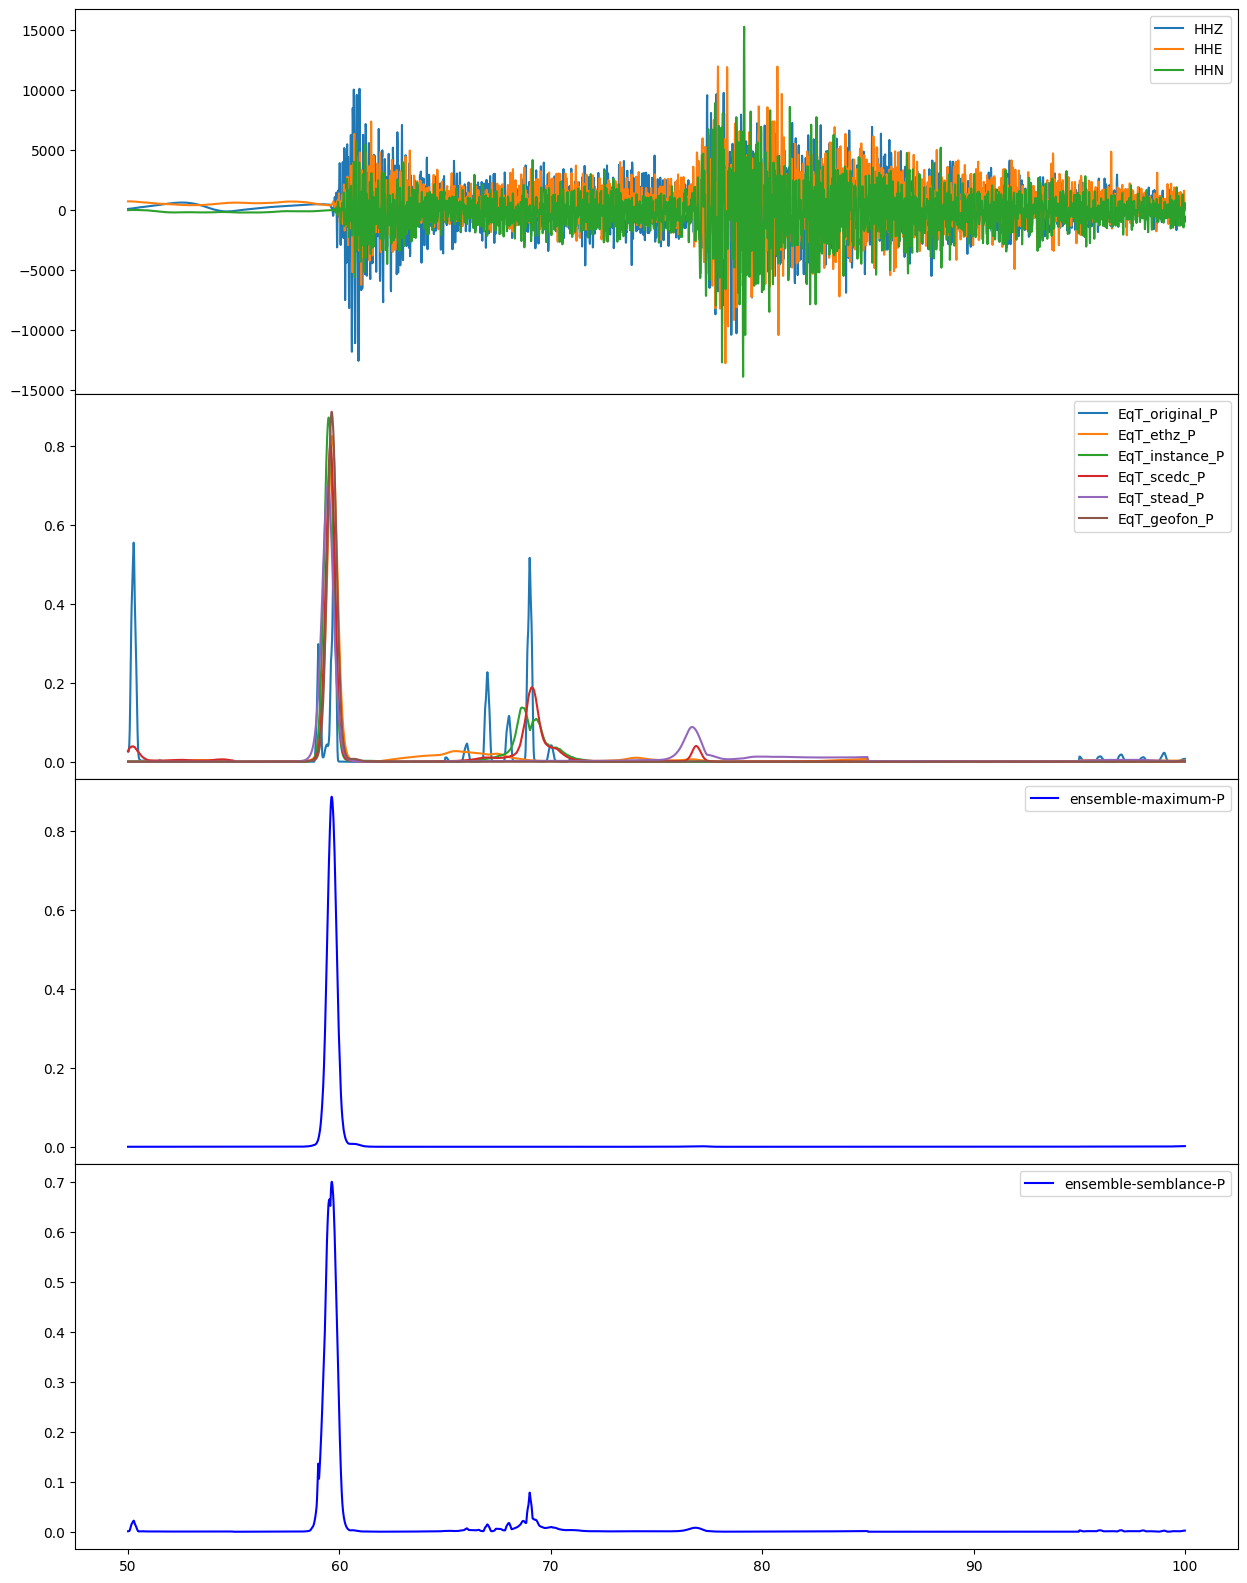

In [15]:
# compare base predictions and simple ensemble for P estimation
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0})

pretrain_mdl_list = ['original', 'ethz', 'instance', 'scedc', 'stead', 'geofon']
# plot zoomed-in data
for i in range(3):
    tvec = stream[i].times()
    tind = np.where((tvec >= 50) & (tvec <= 100))[0]
    axs[0].plot(tvec[tind], stream[i].data[tind], label=stream[i].stats.channel)

# plot all eqt predictions
for ii in range(ntr):    
    axs[1].plot(tvec[tind], preds_P[ii,tind], label='EqT_'+pretrain_mdl_list[ii]+'_P')
    
# plot ensemble maximum estimation
axs[2].plot(tvec[tind], max_pred_P[tind], 'b', label='ensemble-maximum-P')

# plot ensemble semblance estimation
axs[3].plot(tvec[tind], smb_pred_P[tind], 'b', label='ensemble-semblance-P')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()

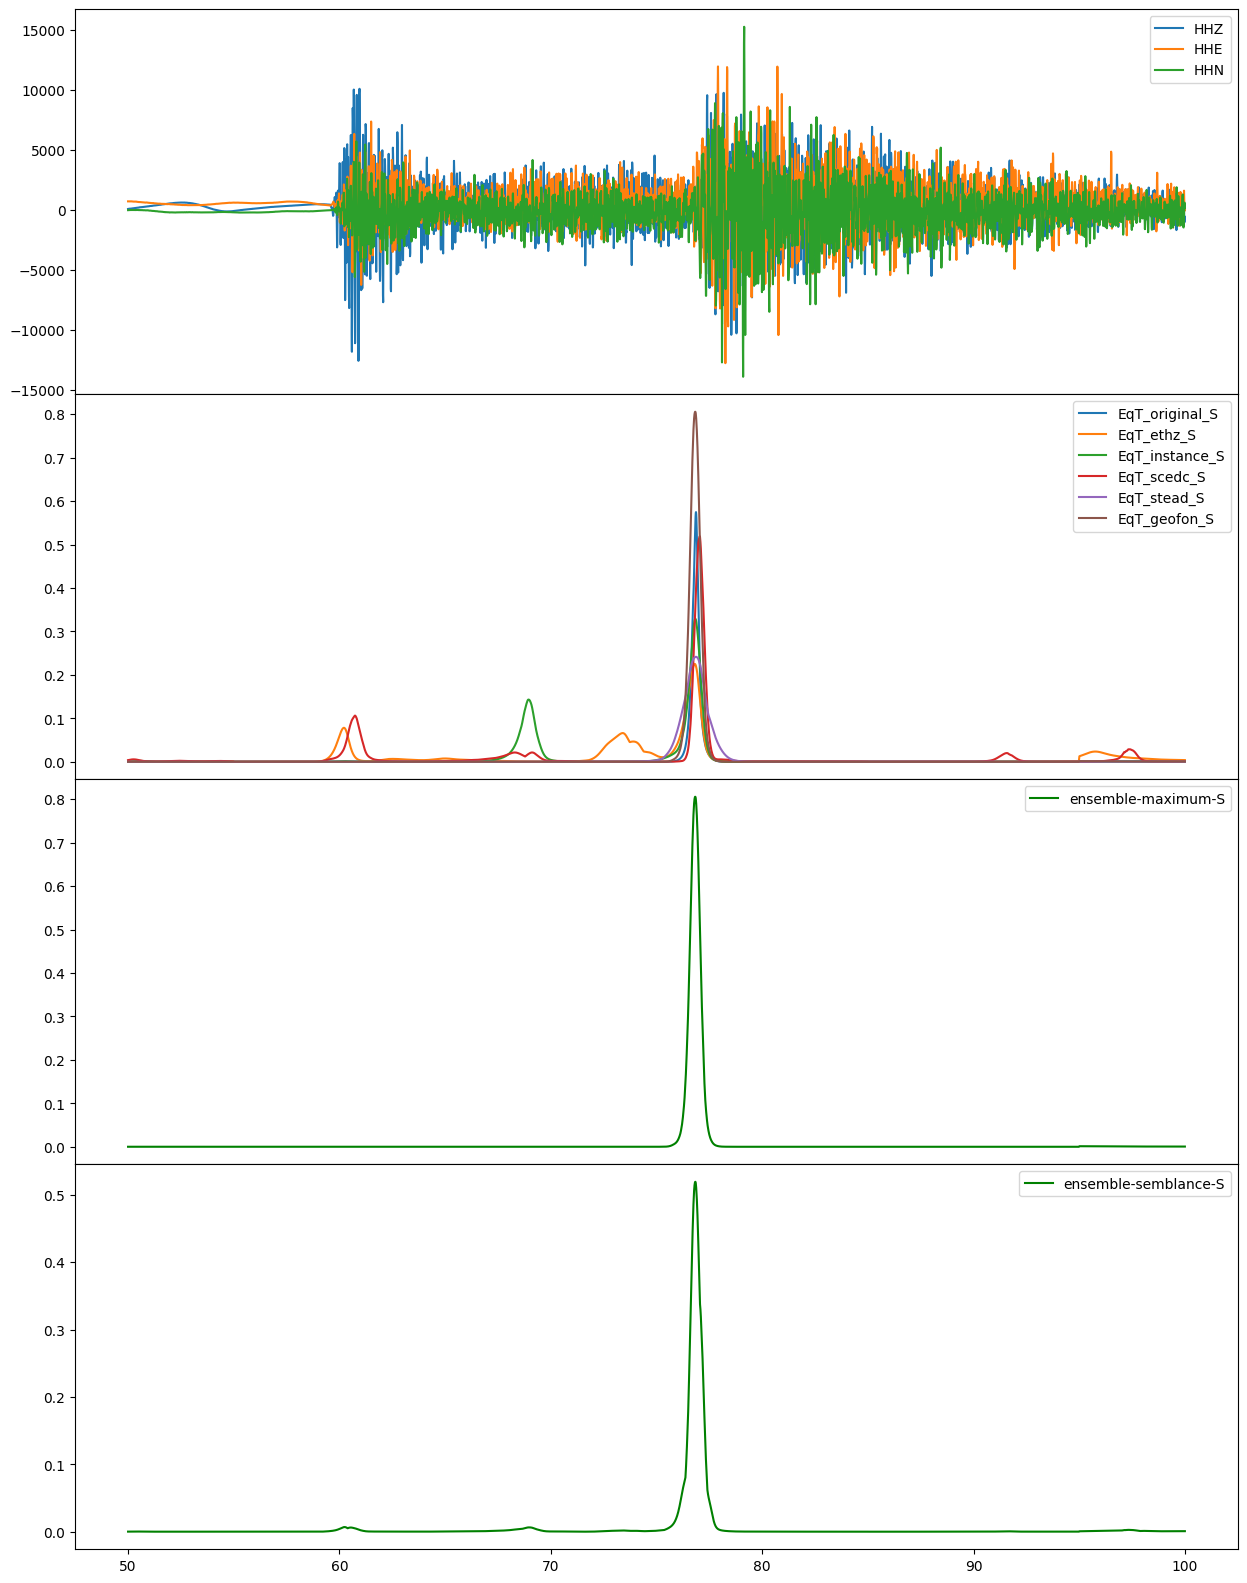

In [16]:
# compare base predictions and simple ensemble for S estimation
fig = plt.figure(figsize=(15, 20))
axs = fig.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0})

pretrain_mdl_list = ['original', 'ethz', 'instance', 'scedc', 'stead', 'geofon']
# plot zoomed-in data
for i in range(3):
    tvec = stream[i].times()
    tind = np.where((tvec >= 50) & (tvec <= 100))[0]
    axs[0].plot(tvec[tind], stream[i].data[tind], label=stream[i].stats.channel)

# plot all eqt predictions
for ii in range(ntr):    
    axs[1].plot(tvec[tind], preds_S[ii,tind], label='EqT_'+pretrain_mdl_list[ii]+'_S')
    
# plot ensemble maximum estimation
axs[2].plot(tvec[tind], max_pred_S[tind], 'g', label='ensemble-maximum-S')

# plot ensemble semblance estimation
axs[3].plot(tvec[tind], smb_pred_S[tind], 'g', label='ensemble-semblance-S')

axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[3].legend()